In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


In [2]:
# Load the dataset

data = pd.read_csv('debutanizer_data.txt', delim_whitespace=True)
#data = shuffle(data, random_state=42) 

X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values   #target variable

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.33, random_state=42)  # 67% train, 33% temp
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  
scaler = StandardScaler()

C:\Users\ARITRA SARKAR\AppData\Local\Temp\ipykernel_19104\1664276859.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('debutanizer_data.txt', delim_whitespace=True)


In [3]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
# Step 4: Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

model = SimpleNN(X_train.shape[1])

In [6]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []


# Step 7: Train with Validation
epochs = 1000
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train)
    losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 100/1000, Train Loss: 0.0113, Val Loss: 0.0132
Epoch 200/1000, Train Loss: 0.0077, Val Loss: 0.0107
Epoch 300/1000, Train Loss: 0.0056, Val Loss: 0.0091
Epoch 400/1000, Train Loss: 0.0043, Val Loss: 0.0083
Epoch 500/1000, Train Loss: 0.0035, Val Loss: 0.0078
Epoch 600/1000, Train Loss: 0.0030, Val Loss: 0.0075
Epoch 700/1000, Train Loss: 0.0026, Val Loss: 0.0073
Epoch 800/1000, Train Loss: 0.0022, Val Loss: 0.0070
Epoch 900/1000, Train Loss: 0.0020, Val Loss: 0.0069
Epoch 1000/1000, Train Loss: 0.0019, Val Loss: 0.0068


In [7]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test).squeeze()
    test_outputs = torch.sigmoid(test_logits)
    predictions = (test_outputs >= 0.5).float()

    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9823


In [8]:
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
   test_pred = model(X_test)
   tes_rmse=np.sqrt(criterion(test_pred, y_test).item())
   test_r2 = 1 - (torch.sum((y_test - test_pred) ** 2) / torch.sum((y_test - y_test.mean()) ** 2)).item()
print(f"Test RMSE: {tes_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}")

Test RMSE: 0.0893
Test R^2: 0.6595


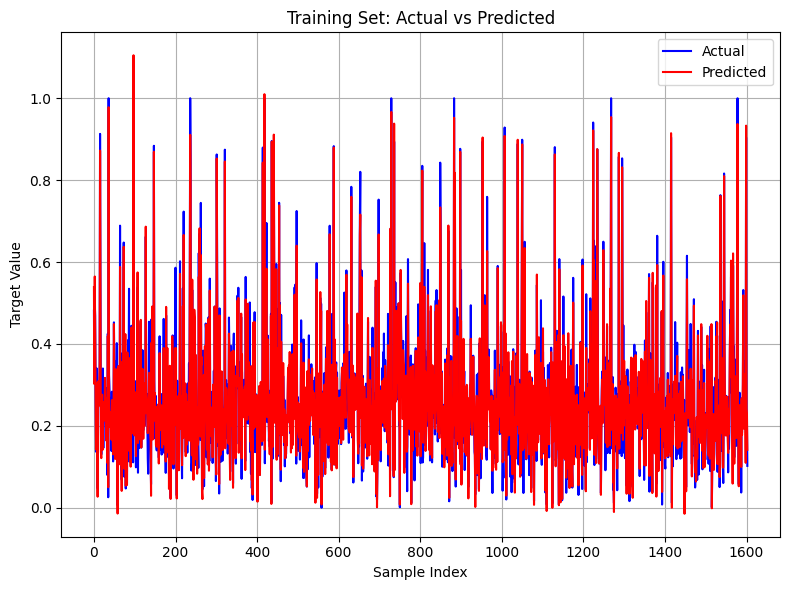

In [9]:
with torch.no_grad():
    y_train_pred = model(X_train).numpy()

plt.figure(figsize=(8, 6))
plt.plot(y_train.numpy(), label="Actual", color="blue")
plt.plot(y_train_pred, label="Predicted", color="red")
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

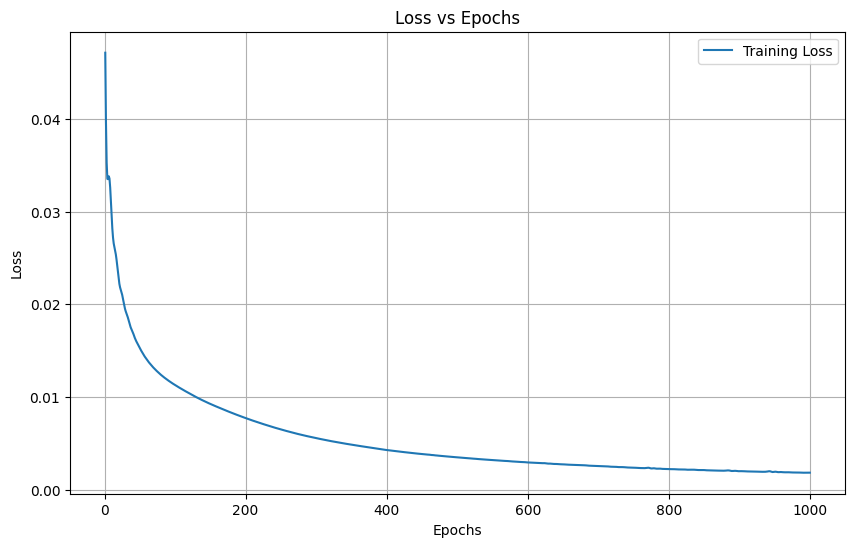

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()